### Textract Optical Character Recognition for PDFs

#### Imports

In [1]:
import boto3
import time

import re
import os
import json
import numpy as np
import pandas as pd
import datetime as dt

#### Upload documents to the AWS Bucket

The below may take a few minutes to run, all documents in the specified folder will be uploaded to the cloud

In [2]:
# Set to the directory containing the pdfs
input_dir = "/Users/nicolebrye/Desktop/HGC/Data_Management/pdf-ocr/SD4000s_20220426_24-2"

# Set to the directory where the pdfs will be stored
output_dir = "/Users/nicolebrye/Desktop/HGC/Data_Management/pdf-ocr/Test_PDFs"

# Set to the name of the AWS S3 bucket
s3BucketName = "pdf-ocr-bucket"


In [3]:
# Upload the documents to the cloud
PDFS = os.listdir(input_dir)

# Call s3 as a resource
s3 = boto3.resource("s3")

# for pdf in PDFS:
#     data = open(os.path.join(input_dir, pdf), "rb")
#     s3.Bucket(s3BucketName).put_object(Key = pdf, Body = data)

#### Important Global Variables

In [4]:
# Column names for output
cols = ['Batch_UID', 'Exam_UID', 'InstrumentModel', 'InstrumentSerialNumber', 
        'InstrumentSoftwareVersion', 'PatientID', 'GIVEN_NAME', 'LAST_NAME', 
        'StudyCode', 'aeDOB', 'Eye', 'SeriesDateTime',
        'aeExamDate', 'aeExamTime', 'ExamDuration', 'aeIsShileyClinicHFAExam', 'aeDIGSTestType',
        'TestType', 'TestPattern', 'TestStrategy', 'StimulusColor', 'StimulusSize', 
        'BackgroundColor', 'FixationTarget', 'FixationMonitor', 'TrialRXSphereRaw', 
        'TrialRXCylRaw', 'TrialRXAxisRaw', 'PupilDiameter', 'VAType', 'BlindSpotX','BlindSpotY',
        'BlindSpotStimulusSize', 'FalseNegativePercent', 'FalsePositivePercent',
        'aeFixationCheckPercentage', 'FovealResult', 'FovealThreshold', 'ClinicalNotes',
        'SFStatus', 'SF', 'SFProb', 'SWAPFTGeneralHeight', 'GHTType', 'MD', 'MDProb', 'PSD',
        'PSDProb', 'CPSD', 'CPSDProb', 'FovealThresholdProb', 'aePDPCen4LT5Count', 
        'aeHasHighRawThreshold', 'FLAGAssessment', 'FLAGSeverity', 'AGISScore', 'AGISNas', 
        'AGISInf', 'AGISSup', 'GHSupThrSum', 'GHSupThrMean', 'GHSupThrStd', 'GHSupTDSum',
        'GHSupTDMean', 'GHSupTDStd', 'GHSupPDSum', 'GHSupPDMean', 'GHSupPDStd', 'GHSupPDCntLT50p',
        'GHSupPDCntLT10p', 'GHSupNasThrSum', 'GHSupNasThrMean', 'GHSupNasThrStd', 'GHSupNasTDSum',
        'GHSupNasTDMean', 'GHSupNasTDStd', 'GHSupNasPDSum', 'GHSupNasPDMean', 'GHSupNasPDStd',
        'GHSupNasPDCntLT50p', 'GHSupNasPDCntLT10p', 'GHInfThrSum', 'GHInfThrMean', 'GHInfThrStd',
        'GHInfTDSum', 'GHInfTDMean', 'GHInfTDStd', 'GHInfPDSum', 'GHInfPDMean', 'GHInfPDStd',
        'GHInfPDCntLT50p', 'GHInfPDCntLT10p', 'GHInfNasThrSum', 'GHInfNasThrMean', 'GHInfNasThrStd',
        'GHInfNasTDSum', 'GHInfNasTDMean', 'GHInfNasTDStd', 'GHInfNasPDSum', 'GHInfNasPDMean',
        'GHInfNasPDStd', 'GHInfNasPDCntLT50p', 'GHInfNasPDCntLT10p', 'GHCentralThrSum',
        'GHCentralThrMean', 'GHCentralThrStd', 'GHCentralTDSum', 'GHCentralTDMean', 'GHCentralTDStd',
        'GHCentralPDSum', 'GHCentralPDMean', 'GHCentralPDStd', 'GHCentralPDCntLT50p', 
        'GHCentralPDCntLT10p', 'GHTemporalThrSum', 'GHTemporalThrMean', 'GHTemporalThrStd',
        'GHTemporalTDSum', 'GHTemporalTDMean', 'GHTemporalTDStd', 'GHTemporalPDSum', 
        'GHTemporalPDMean', 'GHTemporalPDStd', 'GHTemporalPDCntLT50p', 'GHTemporalPDCntLT10p',
        'N9_S27_Thr', 'N3_S27_Thr', 'T3_S27_Thr', 'T9_S27_Thr', 'N15_S21_Thr', 'N9_S21_Thr',
        'N3_S21_Thr', 'T3_S21_Thr', 'T9_S21_Thr', 'T15_S21_Thr', 'N21_S15_Thr', 'N15_S15_Thr', 
        'N9_S15_Thr', 'N3_S15_Thr', 'T3_S15_Thr', 'T9_S15_Thr', 'T15_S15_Thr', 'T21_S15_Thr',
        'N27_S9_Thr', 'N21_S9_Thr', 'N15_S9_Thr', 'N9_S9_Thr', 'N3_S9_Thr', 'T3_S9_Thr', 'T9_S9_Thr',
        'T15_S9_Thr', 'T21_S9_Thr', 'T27_S9_Thr', 'N27_S3_Thr', 'N21_S3_Thr', 'N15_S3_Thr', 
        'N9_S3_Thr',  'N3_S3_Thr', 'T3_S3_Thr', 'T9_S3_Thr', 'T21_S3_Thr', 'T27_S3_Thr', 
        'N27_I3_Thr', 'N21_I3_Thr', 'N15_I3_Thr', 'N9_I3_Thr', 'N3_I3_Thr', 'T3_I3_Thr', 'T9_I3_Thr', 
        'T21_I3_Thr', 'T27_I3_Thr', 'N27_I9_Thr', 'N21_I9_Thr', 'N15_I9_Thr', 'N9_I9_Thr', 
        'N3_I9_Thr', 'T3_I9_Thr', 'T9_I9_Thr', 'T15_I9_Thr', 'T21_I9_Thr', 'T27_I9_Thr', 
        'N21_I15_Thr', 'N15_I15_Thr', 'N9_I15_Thr', 'N3_I15_Thr', 'T3_I15_Thr', 'T9_I15_Thr', 
        'T15_I15_Thr', 'T21_I15_Thr', 'N15_I21_Thr', 'N9_I21_Thr', 'N3_I21_Thr', 'T3_I21_Thr',
        'T9_I21_Thr', 'T15_I21_Thr', 'N9_I27_Thr', 'N3_I27_Thr', 'T3_I27_Thr', 'T9_I27_Thr', 
        'N9_S27_TD', 'N3_S27_TD', 'T3_S27_TD', 'T9_S27_TD', 'N15_S21_TD', 'N9_S21_TD', 'N3_S21_TD', 
        'T3_S21_TD', 'T9_S21_TD', 'T15_S21_TD', 'N21_S15_TD', 'N15_S15_TD', 'N9_S15_TD', 'N3_S15_TD',
        'T3_S15_TD', 'T9_S15_TD', 'T15_S15_TD', 'T21_S15_TD', 'N27_S9_TD', 'N21_S9_TD', 'N15_S9_TD', 
        'N9_S9_TD', 'N3_S9_TD', 'T3_S9_TD', 'T9_S9_TD', 'T15_S9_TD', 'T21_S9_TD', 'T27_S9_TD', 
        'N27_S3_TD', 'N21_S3_TD', 'N15_S3_TD', 'N9_S3_TD', 'N3_S3_TD', 'T3_S3_TD', 'T9_S3_TD', 
        'T21_S3_TD', 'T27_S3_TD', 'N27_I3_TD', 'N21_I3_TD', 'N15_I3_TD', 'N9_I3_TD', 'N3_I3_TD',
        'T3_I3_TD', 'T9_I3_TD', 'T21_I3_TD', 'T27_I3_TD', 'N27_I9_TD', 'N21_I9_TD', 'N15_I9_TD', 
        'N9_I9_TD', 'N3_I9_TD', 'T3_I9_TD', 'T9_I9_TD', 'T15_I9_TD', 'T21_I9_TD', 'T27_I9_TD',
        'N21_I15_TD', 'N15_I15_TD', 'N9_I15_TD', 'N3_I15_TD', 'T3_I15_TD', 'T9_I15_TD', 'T15_I15_TD',
        'T21_I15_TD', 'N15_I21_TD', 'N9_I21_TD', 'N3_I21_TD', 'T3_I21_TD', 'T9_I21_TD', 'T15_I21_TD',
        'N9_I27_TD', 'N3_I27_TD', 'T3_I27_TD', 'T9_I27_TD', 'N9_S27_PD', 'N3_S27_PD', 'T3_S27_PD', 
        'T9_S27_PD', 'N15_S21_PD', 'N9_S21_PD', 'N3_S21_PD', 'T3_S21_PD', 'T9_S21_PD', 'T15_S21_PD',
        'N21_S15_PD', 'N15_S15_PD', 'N9_S15_PD', 'N3_S15_PD', 'T3_S15_PD', 'T9_S15_PD', 'T15_S15_PD',
        'T21_S15_PD', 'N27_S9_PD', 'N21_S9_PD', 'N15_S9_PD', 'N9_S9_PD', 'N3_S9_PD', 'T3_S9_PD', 
        'T9_S9_PD', 'T15_S9_PD', 'T21_S9_PD', 'T27_S9_PD', 'N27_S3_PD', 'N21_S3_PD', 'N15_S3_PD', 
        'N9_S3_PD', 'N3_S3_PD', 'T3_S3_PD', 'T9_S3_PD', 'T21_S3_PD', 'T27_S3_PD', 'N27_I3_PD',
        'N21_I3_PD', 'N15_I3_PD', 'N9_I3_PD', 'N3_I3_PD', 'T3_I3_PD', 'T9_I3_PD', 'T21_I3_PD', 
        'T27_I3_PD', 'N27_I9_PD', 'N21_I9_PD', 'N15_I9_PD', 'N9_I9_PD', 'N3_I9_PD', 'T3_I9_PD', 
        'T9_I9_PD', 'T15_I9_PD', 'T21_I9_PD', 'T27_I9_PD', 'N21_I15_PD', 'N15_I15_PD', 'N9_I15_PD',
        'N3_I15_PD', 'T3_I15_PD', 'T9_I15_PD', 'T15_I15_PD', 'T21_I15_PD', 'N15_I21_PD', 'N9_I21_PD', 
        'N3_I21_PD', 'T3_I21_PD', 'T9_I21_PD', 'T15_I21_PD', 'N9_I27_PD', 'N3_I27_PD', 'T3_I27_PD',
        'T9_I27_PD', 'N9_S27_TDP', 'N3_S27_TDP', 'T3_S27_TDP', 'T9_S27_TDP', 'N15_S21_TDP', 'N9_S21_TDP', 
        'N3_S21_TDP', 'T3_S21_TDP', 'T9_S21_TDP', 'T15_S21_TDP', 'N21_S15_TDP', 'N15_S15_TDP', 
        'N9_S15_TDP', 'N3_S15_TDP', 'T3_S15_TDP', 'T9_S15_TDP', 'T15_S15_TDP', 'T21_S15_TDP', 
        'N27_S9_TDP', 'N21_S9_TDP', 'N15_S9_TDP', 'N9_S9_TDP', 'N3_S9_TDP', 'T3_S9_TDP', 'T9_S9_TDP', 
        'T15_S9_TDP', 'T21_S9_TDP', 'T27_S9_TDP', 'N27_S3_TDP', 'N21_S3_TDP', 'N15_S3_TDP', 'N9_S3_TDP', 
        'N3_S3_TDP', 'T3_S3_TDP', 'T9_S3_TDP', 'T21_S3_TDP', 'T27_S3_TDP', 'N27_I3_TDP', 'N21_I3_TDP',
        'N15_I3_TDP', 'N9_I3_TDP', 'N3_I3_TDP', 'T3_I3_TDP', 'T9_I3_TDP', 'T21_I3_TDP', 'T27_I3_TDP',
        'N27_I9_TDP', 'N21_I9_TDP', 'N15_I9_TDP', 'N9_I9_TDP', 'N3_I9_TDP', 'T3_I9_TDP', 'T9_I9_TDP',
        'T15_I9_TDP', 'T21_I9_TDP', 'T27_I9_TDP', 'N21_I15_TDP', 'N15_I15_TDP', 'N9_I15_TDP', 
        'N3_I15_TDP', 'T3_I15_TDP', 'T9_I15_TDP', 'T15_I15_TDP', 'T21_I15_TDP', 'N15_I21_TDP', 
        'N9_I21_TDP', 'N3_I21_TDP', 'T3_I21_TDP', 'T9_I21_TDP', 'T15_I21_TDP', 'N9_I27_TDP', 
        'N3_I27_TDP', 'T3_I27_TDP', 'T9_I27_TDP', 'N9_S27_PDP', 'N3_S27_PDP', 'T3_S27_PDP', 
        'T9_S27_PDP', 'N15_S21_PDP', 'N9_S21_PDP', 'N3_S21_PDP', 'T3_S21_PDP', 'T9_S21_PDP', 
        'T15_S21_PDP', 'N21_S15_PDP', 'N15_S15_PDP', 'N9_S15_PDP', 'N3_S15_PDP', 'T3_S15_PDP', 
        'T9_S15_PDP', 'T15_S15_PDP', 'T21_S15_PDP', 'N27_S9_PDP', 'N21_S9_PDP', 'N15_S9_PDP',
        'N9_S9_PDP', 'N3_S9_PDP', 'T3_S9_PDP', 'T9_S9_PDP', 'T15_S9_PDP', 'T21_S9_PDP', 'T27_S9_PDP', 
        'N27_S3_PDP', 'N21_S3_PDP', 'N15_S3_PDP', 'N9_S3_PDP', 'N3_S3_PDP', 'T3_S3_PDP', 
        'T9_S3_PDP', 'T21_S3_PDP', 'T27_S3_PDP', 'N27_I3_PDP', 'N21_I3_PDP', 'N15_I3_PDP',
        'N9_I3_PDP', 'N3_I3_PDP', 'T3_I3_PDP', 'T9_I3_PDP', 'T21_I3_PDP', 'T27_I3_PDP',
        'N27_I9_PDP', 'N21_I9_PDP', 'N15_I9_PDP', 'N9_I9_PDP', 'N3_I9_PDP', 'T3_I9_PDP', 
        'T9_I9_PDP', 'T15_I9_PDP', 'T21_I9_PDP', 'T27_I9_PDP', 'N21_I15_PDP', 'N15_I15_PDP',
        'N9_I15_PDP', 'N3_I15_PDP', 'T3_I15_PDP', 'T9_I15_PDP', 'T15_I15_PDP', 'T21_I15_PDP',
        'N15_I21_PDP', 'N9_I21_PDP', 'N3_I21_PDP', 'T3_I21_PDP', 'T9_I21_PDP', 'T15_I21_PDP',
        'N9_I27_PDP', 'N3_I27_PDP', 'T3_I27_PDP', 'T9_I27_PDP', 'cAutoQCStatus', 'QCFieldUsable',
        'QCReliable', 'cQCFN33Status', 'cQCAHSManualStatus', 'cQCRimArtifactStatus',
        'cQCInattentionStatus', 'cQCLearningEffectStatus', 'cQCFatigueStatus', 'cQCFixationStatus', 
        'cQCOtherDefectStatus', 'cQCUnreliableByTechnicianStatus', 'cQCUnaccPupilSizeStatus','VFI',
        'kPrevUsable_ExamTimeStamp', 'aeExamTimeStamp', 'kNextUsable_ExamTimeStamp', 
        'kPrevUsable_FLAGAssessment', 'kNextUsable_FLAGAssessment', 
        'cFLAG_Confirmation_Status_ByTestType', 'cIsABNORMAL_FLAG_Confirmed_ByTestType',
        'cIsNORMAL_FLAG_Confirmed_ByTestType', 'cCnt_TDP_LessThan5', 'cCnt_PDP_LessThan5',
        'cCnt_TDP_LessThan2', 'cCnt_PDP_LessThan2', 'cCnt_TDP_LessThan1', 'cCnt_PDP_LessThan1',
        'cCnt_TDP_LessThan05', 'cCnt_PDP_LessThan05', 'kUsedADAGESBL09','sFLAGAbn3ConsecConfirmed',
        'sFLAGAbn3ConsecUnconfirmed', 'sFLAGNorm3ConsecConfirmed', 'sFLAGNorm3ConsecUnconfirmed',
        'LowPatientReliabilityStatus']

#### Important Global Variables

In [5]:
# Initialize the s3 bucket
bucket = s3.Bucket(s3BucketName)

# Loop through all the files in the bucket and append them to a list
files = []
for i in bucket.objects.all():
    files.append(i.key)

In [6]:
# Subset the files, just for testing
files = files[:5]

#### Key Value Function

This function converts the raw text of the PDF to key value pairs which can have information extracted easily. This must be called before the raw text function.

In [6]:
def key_value_output(text):
    
    # Convert text into key value pairs
    temp = {}
    for i in range(len(text)):
    
        val = text[i].split(":")
    
        if len(val) == 2:
            if val[1] == "":
                temp[val[0].strip()] = text[i+1].strip().strip(",")
            else:
                temp[val[0].strip()] = val[1].strip().strip(",")
                
    # Save the keys in a Series
    KEYS = pd.Series(temp.keys())
                
    # Initialize pandas DataFrame
    output = pd.DataFrame(columns=cols, index=[0])
    
    # Important dates
    DOB = pd.to_datetime(temp["Date of Birth"])
    VIS = pd.to_datetime(temp["Date"])

    # Patient Info
    output["PatientID"]  = temp["Patient ID"]
    output["GIVEN_NAME"] = temp["Patient"]
    output["LAST_NAME"]  = temp["Patient"]
    output["aeDOB"] = str(DOB.month) + "/" + str(DOB.day) + "/" + str(DOB.year) #[-2:]
    
    # Visit Info
    output["aeExamTime"] = temp["Time"].split()[0]
    output["aeExamDate"] = str(VIS.month) + "/" + str(VIS.day) + "/" + str(VIS.year) #[-2:]
    output["TestStrategy"] = temp["Strategy"]
    output["ExamDuration"] = temp["Test Duration"]
    
    # Eye Info
    output["VAType"] = temp["Visual Acuity"]
    
    MDKEY  = KEYS[KEYS.str.contains("MD").idxmax()]
    PSDKEY = KEYS[KEYS.str.contains("PSD").idxmax()]
    
    # MD and MDProb
    if temp[MDKEY].endswith("dB"):
        output["MD"]     = temp[MDKEY].strip(" dB")
        output["MDProb"] = "Not Significant"
        
    elif temp[MDKEY].endswith("%"):
        output["MD"]     = temp[MDKEY].split(" dB ")[0]
        output["MDProb"] = temp[MDKEY].split(" dB ")[1]

    
    # PSD and PSDProb
    if temp[PSDKEY].endswith("dB"):
        output["PSD"]     = temp[PSDKEY].strip(" dB")
        output["PSDProb"] = "Not Significant"
        
    elif temp[PSDKEY].endswith("%"):
        output["PSD"]     = temp[PSDKEY].split(" dB ")[0]
        output["PSDProb"] = temp[PSDKEY].split(" dB ")[1]

    
    # Other Info
    output["FixationTarget"]  = temp["Fixation Target"]
    output["FixationMonitor"] = temp["Fixation Monitor"]
    output["StimulusSize"]    = temp["Stimulus"].split(", ")[0]
    output["StimulusColor"]   = temp["Stimulus"].split()[1]
    output["BackgroundColor"] = output["StimulusColor"] + " (" + temp["Background"] + ")"
    output["PupilDiameter"]   = temp["Pupil Diameter"].split()[0]
    output["FovealThreshold"] = temp["Fovea"].strip(" dB")
    output["GHTType"]         = temp["GHT"]
    
    try:
        output["VFI"] = temp["VFI"].strip("%")
    except:
        pass
    
    #output["FIXATION_CHECK_ERRORS"]  = temp["Fixation Losses"].split("/")[0]
    #output["FIXATION_CHECK_TRIALS"]  = temp["Fixation Losses"].split("/")[1]
    err, trials = temp["Fixation Losses"].split()[0].split("/")
    output["aeFixationCheckPercentage"] = round(float(err) / float(trials) * 100, 2)
    output["FalsePositivePercent"] = temp["False POS Errors"].strip("%")
    output["FalseNegativePercent"] = temp["False NEG Errors"].strip("%")
    #output["INSTRUMENT_MANUFACTURER"] = "Carl Zeiss Meditec"
    
    return output

#### Raw Text Function

This function takes an output DataFrame provided by the key value function and a list of text from the pdf. This function analyzes the raw text to extract values from the pdf.

In [16]:
def raw_text_output(output, text):
    
    # Find the thr points as well as other important information
    count  = 0
    scount = 0
    THR   = []
    POINTS = []
    
    for i, x in enumerate(text):
        
        point2 = re.search("^(\-\d{1,2}|\d{1,2}|\-\d{1,2}\s[^A-z]+|\d{1,2}\s[^A-z]+|<0)$", x)
        negp   = re.search("^(\-\d{1,2}\-[^A-z]+|\d{1,2}\-[^A-z]+)$", x)

        point  = re.search("^\d{2}$", x)
        small  = re.search("^\d$", x)
        #point2 = re.search("^(\d{1,2}|\-<0)$", x)
        
        
        eye    = re.search("(^OD$|^OS$)", x)
        test   = re.search("\s\d{2}-\d\s", x)
        inst   = re.search("HFA", x)
        vers   = re.search("Version", x)
        rx     = re.search("Rx:\s.*", x)
        field  = re.search("°", x)
        status = re.search("\*{3}(.*)\*{3}", x)
        
        if point2:
            value  = point2.group(0).split()
            POINTS = POINTS + value
            
        if negp:
            fbool = negp.group(0).startswith("-")
            nums  = negp.group(0).strip("-").split("-")
            
            if fbool:
                value = list(map(lambda x: "-" + x, nums))
            else:
                value = nums[0] + list(map(lambda x: "-" + x, nums[1:]))
                
            POINTS = POINTS + value
        
        if point:
            count += 1
            THR.append(x)
            
        if small:
            scount += 1
                
            if scount == 1 and count < 40:
                THR.append(x)

        if eye:
            Eye = eye.group(0)

        if test:
            words = x.split()

            TestPattern = " ".join([words[0], words[1]])
            TestType    = words[2]

        if inst:
            inst_info = x.split()

            InstrumentName = " ".join([inst_info[0], inst_info[1]])
            InstrumentModel = inst_info[-1].split("-")[0]
            InstrumentSerialNumber = inst_info[-1].split("-")[1][:4]
            InstrumentSoftwareVersion = inst_info[-1].split("/")[-1]

        if vers:
            Version = x.split()[1]  

        if rx:
            rxval = rx.group(0)
            TrialRXSphereRaw = re.findall("(\d+\.\d+)\s?DS", rxval)[0]
            TrialRXCylRaw    = re.findall("(\d+\.\d+)\s?DC", rxval)[0]
            TrialRXAxisRaw   = re.findall("X(.*)", rxval)[0]

        if field:
            FieldSize = x.strip()
            
        if status:
            LowPatientReliabilityStatus = status.strip("***").strip()

    # Remove age
    #THR = THR[1:]
    POINTS = POINTS[1:]
    print(POINTS)
    print(len(POINTS))
    
    if len(POINTS) == 158:
        THR  = POINTS[:54]
        TDPD = POINTS[54:]
         
    # Find the TD and PD Points
    TDPD = []
    for i, x in enumerate(text):

        point = re.search("(^\-\d|^\d|^\-\d\s[^A-z]+|\d\s[^A-z]+)$", x)

        if point:
            value = point.group(0).split()
            TDPD  = TDPD + value
           
    # Remove small threshold point
    if len(TDPD) != 104:
        TDPD = TDPD[1:]

    # Split into TD and PD
    TD = TDPD[:4] + TDPD[8:14] + TDPD[20:28] + TDPD[36:44] + TDPD[52:60] + TDPD[68:76] + TDPD[84:90] + TDPD[96:100]
    PD = TDPD[4:8] + TDPD[14:20] + TDPD[28:36] + TDPD[44:52] + TDPD[60:68] + TDPD[76:84] + TDPD[90:96] + TDPD[100:]
    
    # Order the plot points
    if Eye == "OS":
        ORDER = ['T9_S21', 'T3_S21', 'N3_S21', 'N9_S21', 'T15_S15',
                 'T9_S15', 'T3_S15', 'N3_S15', 'N9_S15', 'N15_S15',
                 'T21_S9', 'T15_S9', 'T9_S9', 'T3_S9', 'N3_S9','N9_S9',
                 'N15_S9', 'N21_S9', 'T21_S3', 'T15_S3', 'T9_S3','T3_S3',
                 'N3_S3', 'N9_S3', 'N15_S3', 'N21_S3', 'N27_S3', 
                 'T21_I3', 'T15_I3', 'T9_I3', 'T3_I3', 'N3_I3', 'N9_I3',
                 'N15_I3', 'N21_I3', 'N27_I3', 'T21_I9', 'T15_I9',
                 'T9_I9', 'T3_I9', 'N3_I9', 'N9_I9', 'N15_I9', 'N21_I9',
                 'T15_I15', 'T9_I15', 'T3_I15', 'N3_I15', 'N9_I15',
                 'N15_I15', 'T9_I21', 'T3_I21', 'N3_I21', 'N9_I21'
                ]
        blind_spots = [19, 28]
        
    else:
        ORDER = ['N9_S21', 'N3_S21', 'T3_S21', 'T9_S21', 'N15_S15',
                 'N9_S15', 'N3_S15', 'T3_S15', 'T9_S15', 'T15_S15',
                 'N21_S9', 'N15_S9', 'N9_S9', 'N3_S9', 'T3_S9',
                 'T9_S9', 'T15_S9', 'T21_S9', 'N27_S3', 'N21_S3',
                 'N15_S3', 'N9_S3', 'N3_S3', 'T3_S3', 'T9_S3',
                 'T15_S3', 'T21_S3', 'N27_I3', 'N21_I3', 'N15_I3',
                 'N9_I3', 'N3_I3', 'T3_I3', 'T9_I3', 'T15_I3',
                 'T21_I3', 'N21_I9', 'N15_I9', 'N9_I9', 'N3_I9',
                 'T3_I9', 'T9_I9', 'T15_I9', 'T21_I9', 'N15_I15',
                 'N9_I15', 'N3_I15', 'T3_I15', 'T9_I15', 'T15_I15',
                 'N9_I21', 'N3_I21', 'T3_I21', 'T9_I21']
        blind_spots = [25, 34]
        
    if len(THR) == 54:
        del THR[blind_spots[1]]
        del THR[blind_spots[0]]
    elif len(THR) == 53:
        del THR[blind_spots[0]]
        
    ORDER.remove("T15_S3")
    ORDER.remove("T15_I3")

    thr_order = [x + "_Thr" for x in ORDER]
    td_order  = [x + "_TD" for x in ORDER]
    pd_order  = [x + "_PD" for x in ORDER]

    # Populate the data frame with thr points
    output["Eye"] = Eye
    
    try:
        output[thr_order] = THR
    except:
        pass

    # Populate the data frame with td points
    output[td_order] = TD

    # Populate the data frame with pd points
    output[pd_order] = PD
    
    # Populate the data frame with other acquired info
    output["TestType"]       = TestType
    output["TestPattern"]    = TestPattern
    output["TrialRXSphereRaw"] = TrialRXSphereRaw
    output["TrialRXCylRaw"]    = TrialRXCylRaw
    output["TrialRXAxisRaw"]   = TrialRXAxisRaw
    #output["FIELD_SIZE"]      = FIELD_SIZE

    #output["INSTRUMENT_NAME"] = INSTRUMENT_NAME
    output["InstrumentModel"] = InstrumentModel
    output["InstrumentSerialNumber"] = InstrumentSerialNumber
    output["InstrumentSoftwareVersion"] = InstrumentSoftwareVersion
    
    try:
        output["LowPatientReliabilityStatus"] = LowPatientReliabilityStatus
    except:
        pass
        

    return output, TestPattern

In [ ]:
def probability_points(output, text):
    
    
    return ...

#### Loop through files and create outputs

This cell uses the two functions from above to create an output. It starts and checks the progress of the OCR job, then formats the output

In [18]:
files = ["SD4000_OD_20090825_SFA_24-2_1145.pdf", 
         "SD4207_19460428_20210915_1040_OD_SFA_CENTRAL_24_2_THRESHOLD_TEST_OD_1.2.276.0.75.2.5.80.25.3.211013101917075.345048637379.pdf",
         "SD4372_19481031_20150715_1312_OD_SFA_CENTRAL_24_2_THRESHOLD_TEST_OD_1.2.276.0.75.2.5.80.25.3.200820152201566.345048637379.pdf"
        ]



In [17]:
# Start up the client
client = boto3.client('textract', 'us-east-1')

CSVS_242 = []
for i, x in enumerate(files):
    
    response = client.start_document_text_detection(
        DocumentLocation={
            'S3Object': {
                'Bucket': s3BucketName,
                'Name': x
            }
        })
    
    jobId = response["JobId"]
    
    # Extract text
    textractmodule = client.get_document_text_detection(JobId=jobId)
    
    # Check if the OCR is complete
    status = textractmodule["JobStatus"]
    
    while(status == "IN_PROGRESS"):
        time.sleep(5)
        textractmodule = client.get_document_text_detection(JobId=jobId)
        status = textractmodule["JobStatus"]
        
    # Extract text from the module
    text = []
    for block in textractmodule["Blocks"]:
        if block["BlockType"] == "LINE":
            text.append(block["Text"])
            
    # First round of outputs
    output = key_value_output(text)
    
    # Second round of outputs
    output, test_type = raw_text_output(output, text)
    
    if test_type == "Central 24-2":
        CSVS_242.append(output)
    
    # Save the output as a csv
#     filename = x.strip(".pdf") + ".csv"
#     output.to_csv(os.path.join(output_dir, filename), index=False)

['29', '31', '27', '30', '32', '31', '31', '30', '31', '31', '29', '32', '32', '32', '32', '32', '30', '30', '27', '29', '31', '32', '32', '32', '32', '29', '33', '31', '32', '32', '33', '33', '33', '33', '10', '31', '32', '32', '33', '34', '33', '33', '32', '31', '32', '31', '32', '33', '32', '32', '33', '32', '32', '27', '2', '4', '0', '4', '-1', '1', '-2', '1', '3', '2', '2', '1', '2', '3', '0', '-1', '-1', '-2', '-1', '0', '1', '2', '1', '0', '1', '1', '1', '1', '-2', '-1', '-2', '-3', '-2', '-2', '-2', '-2', '0', '0', '0', '0', '0', '0', '1', '3', '-3', '-3', '-3', '-3', '-3', '-3', '-2', '0', '4', '2', '0', '1', '1', '0', '1', '1', '1', '-1', '-3', '-2', '-2', '-3', '-2', '-2', '3', '1', '1', '2', '1', '1', '1', '1', '0', '-2', '-2', '-1', '-2', '-2', '-2', '-2', '2', '1', '1', '2', '1', '2', '-1', '-2', '-2', '-1', '-2', '-1', '4', '2', '2', '-2', '1', '-1', '-1', '-5']
158
['<0', '1', '17', '16', '<0', '<0', '1', '3', '22', '21', '<0', '7', '<0', '<0', '0', '<0', '20', '27', '0

ValueError: Columns must be same length as key

In [15]:
re.search("^(<.*|\d{1,2} .*|\-.*)", "dB")

In [94]:
# Save the batch of files as a csv
DF = pd.concat(CSVS_242)
DF.to_csv(os.path.join(output_dir, "24_2.csv"), index = False)

#### Screenshots for points

In [21]:
from pdf2image import convert_from_path
 
# Store Pdf with convert_from_path function
images = convert_from_path('example.pdf')
 
for i in range(len(images)):
   
      # Save pages as images in the pdf
    images[i].save('page'+ str(i) +'.jpg', 'JPEG')

PDFPageCountError: Unable to get page count.
I/O Error: Couldn't open file 'example.pdf': No such file or directory.


#### Individual Testing

In [19]:
#files = ["SD4207_19460428_20210915_1040_OD_SFA_CENTRAL_24_2_THRESHOLD_TEST_OD_1.2.276.0.75.2.5.80.25.3.211013101917075.345048637379.pdf"]

files = files[2]

In [16]:
# Start up the client
client = boto3.client('textract', 'us-east-1')

response = client.start_document_text_detection(
    DocumentLocation={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': files[0]
        }
    })
    
jobId = response["JobId"]
    
# Extract text
textractmodule = client.get_document_text_detection(JobId=jobId)
    
# Check if the OCR is complete
status = textractmodule["JobStatus"]
    
while(status == "IN_PROGRESS"):
    time.sleep(5)
    textractmodule = client.get_document_text_detection(JobId=jobId)
    status = textractmodule["JobStatus"]
        
# Extract text from the module
text = []
for block in textractmodule["Blocks"]:
    if block["BlockType"] == "LINE":
        text.append(block["Text"])

In [35]:
files[1]

'SD4207_19460428_20210915_1040_OD_SFA_CENTRAL_24_2_THRESHOLD_TEST_OD_1.2.276.0.75.2.5.80.25.3.211013101917075.345048637379.pdf'

In [41]:
import PIL.Image as Image

In [22]:
img = np.array(convert_from_path(os.path.join("/Users/nicolebrye/Desktop", files))[0])

In [37]:
img2 = img[1130:1390, 190:480]

In [50]:
img3 = img[1130:1390, 700:990]

In [52]:
im = Image.fromarray(img3)
im.save("/Users/nicolebrye/Desktop/testimg2.jpg")

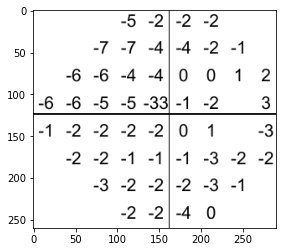

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#img = mpimg.imread('your_image.png')
imgplot = plt.imshow(img3)
plt.show()

In [53]:
imdata = open(os.path.join("/Users/nicolebrye/Desktop", "testimg2.jpg"), "rb")
s3.Bucket("pdf-ocr-images").put_object(Key = "testimg2.jpg", Body = imdata)

s3.Object(bucket_name='pdf-ocr-images', key='testimg2.jpg')

In [54]:
type(imdata)

_io.BufferedReader

In [55]:
imresponse = client.start_document_text_detection(
    DocumentLocation={
        'S3Object': {
            'Bucket': "pdf-ocr-images",
            'Name': "testimg2.jpg"
        }
    })

In [56]:
jobIdImg = imresponse["JobId"]
    
# Extract text
textractmodule = client.get_document_text_detection(JobId=jobIdImg)

In [57]:
# Check if the OCR is complete
status = textractmodule["JobStatus"]
    
while(status == "IN_PROGRESS"):
    time.sleep(5)
    textractmodule = client.get_document_text_detection(JobId=jobIdImg)
    status = textractmodule["JobStatus"]

In [58]:
text = []
for block in textractmodule["Blocks"]:
    if block["BlockType"] == "LINE":
        text.append(block["Text"])

In [59]:
text

['-5 -2',
 '-2 -2',
 '-7 -7 -4',
 '-4 -2 - 1',
 '-6 -6 -4 -4',
 '0 0 1 2',
 '-6 -6 -5 -5 -33 -',
 '-1',
 '-2',
 '3',
 '-1 - - -2 -2 -2 -2',
 '0',
 '1',
 '-3',
 '-2-2-1-1',
 '-1-3 -2 -2',
 '-3 -2-2',
 '-2 -3 - 1',
 '-2 -2',
 '-4 0']

In [38]:
test = []
for i in text:
    a = re.findall("(\d+|\-\d+)", i)
    test = test + a

In [40]:
len(test)

52

In [14]:
# Start up the client
client = boto3.client('textract', 'us-east-1')

obj = s3.Object(s3BucketName, files[0])
fs  = obj.get()['Body'].read()

In [31]:
type(bytearray(fs))

bytearray

In [25]:
import os
import io
import PIL.Image as Image

In [33]:
image = Image.open(io)

ValueError: embedded null byte

In [20]:
pages = convert_from_path('pdf_file', 500)
pages

PDFPageCountError: Unable to get page count.
I/O Error: Couldn't open file 'pdf_file': No such file or directory.


In [63]:
text

['Patient:',
 'SD4207,',
 'ZEISS',
 'Date of Birth: Apr 28, 1946',
 'Gender: Other',
 'Patient ID:',
 'SD4207',
 'UCSD Ophthalmology Research',
 'OD',
 'Single Field Analysis',
 'Central 24-2 Threshold Test',
 'Fixation Monitor:',
 'Gaze/Blind Spot',
 'Stimulus:',
 'III, White',
 'Date:',
 'Sep 15, 2021',
 'Fixation Target:',
 'Central',
 'Background:',
 '31.5 asb',
 'Time:',
 '10:40 AM',
 'Fixation Losses:',
 '4/17 XX',
 'Strategy:',
 'SITA Standard',
 'Age:',
 '75',
 'False POS Errors:',
 '14%',
 'Pupil Diameter:',
 '5.3 mm',
 '*',
 'False NEG Errors:',
 '0%',
 'Visual Acuity:',
 '1.0',
 'Test Duration:',
 '07:55',
 'Rx: +2.50 DS +1.50 DC X 10',
 'Fovea:',
 '31 dB ::',
 '<0',
 '1',
 '17',
 '16',
 '<0',
 '<0',
 '1',
 '3',
 '22',
 '21',
 '<0',
 '7',
 '<0',
 '<0',
 '0',
 '<0',
 '20',
 '27',
 '0',
 '<0',
 '<0',
 '<0',
 '<0',
 '11',
 '0',
 '20',
 '27',
 '30°',
 '-',
 'A',
 '- 30°',
 '30°',
 '16',
 '21',
 '24',
 '26',
 '5',
 '30',
 '28',
 '<0',
 '28',
 '24',
 '27',
 '28',
 '28',
 '25',
 '2

In [70]:
output = key_value_output(text)

raw_text_output(output, text)

10


(  Batch_UID Exam_UID InstrumentModel InstrumentSerialNumber  \
 0       NaN      NaN             750                   8685   
 
   InstrumentSoftwareVersion PatientID GIVEN_NAME LAST_NAME StudyCode  \
 0                       4.2    SD4000     SD4000    SD4000       NaN   
 
        aeDOB  ... cCnt_TDP_LessThan1 cCnt_PDP_LessThan1 cCnt_TDP_LessThan05  \
 0  6/13/1951  ...                NaN                NaN                 NaN   
 
   cCnt_PDP_LessThan05 kUsedADAGESBL09 sFLAGAbn3ConsecConfirmed  \
 0                 NaN             NaN                      NaN   
 
   sFLAGAbn3ConsecUnconfirmed sFLAGNorm3ConsecConfirmed  \
 0                        NaN                       NaN   
 
   sFLAGNorm3ConsecUnconfirmed LowPatientReliabilityStatus  
 0                         NaN                         NaN  
 
 [1 rows x 531 columns],
 'Central 24-2')

In [17]:
for i, x in enumerate(text):

    rx    = re.search("MD", x)
    
    if rx:
        mdidx = i+1
        
        if not text[mdidx].endswith("dB"):
            MD = "Not Significant"
        else:
            MD = text[mdidx].strip(" dB")
        
        print(text[mdidx])
        #print(rx.group(0))

1.15 dB


In [18]:
MD

'1.15'

In [62]:
text

['Patient:',
 'SD4002,',
 'ZEISS',
 'Date of Birth:',
 'Oct 09, 1959',
 'Gender: Other',
 'Patient ID: SD4002',
 'OD',
 'Single Field Analysis',
 'Central 24-2 Threshold Test',
 'Fixation Monitor:',
 'Gaze/Blind Spot',
 'Stimulus:',
 'III, White',
 'Date:',
 'Aug 04, 2010',
 'Fixation Target:',
 'Central',
 'Background:',
 '31.5 asb',
 'Time:',
 '1:00 PM',
 'Fixation Losses:',
 '0/13',
 'Strategy:',
 'SITA-Standard',
 'Age:',
 '50',
 'False POS Errors:',
 '1%',
 'Pupil Diameter:',
 '4.8 mm',
 '*',
 'False NEG Errors:',
 '0%',
 'Visual Acuity:',
 '0.8',
 'Test Duration:',
 '03:47',
 'Rx: +1.25DS +1.50 DC X5',
 'Fovea:',
 '38 dB',
 '31',
 '29',
 '32',
 '30',
 '32',
 '31',
 '31',
 '32',
 '32',
 '31',
 '30',
 '32',
 '33',
 '34',
 '33',
 '32',
 '32',
 '30',
 '31',
 '32',
 '32',
 '33',
 '34',
 '33',
 '32',
 '31',
 '34',
 '30°',
 '-',
 '30°',
 '30°',
 '29',
 '30',
 '32',
 '34',
 '34',
 '34',
 '34',
 '0',
 '32',
 '31',
 '32',
 '34',
 '33',
 '34',
 '33',
 '34',
 '33',
 '33',
 '32',
 '32',
 '32'

In [58]:
re.findall("(\d+\.\d+)\s?DS", rxval)[0]

'2.00'

In [68]:
a = np.array([1, 2, 3, 4])

In [69]:
a[[False, True, False, False]]

array([2])

In [67]:
[1, 2, 3] * 3

[1, 2, 3, 1, 2, 3, 1, 2, 3]